# # Waves simulation Notebook 11

## Introduction 

We use the Fourier method to calculate exact n-th derivatives on a regular spaced grid (to machine precision). This property combined with classical time extrapolation schemes result in the so call Fourier pseudospectral method.  The problem of solving the 1D acoustic wave equation in an homogeneous media

\begin{equation}
\partial_t^2 p(x,t) = c(x)^2 \ \partial_x^2 p(x,t) + s(x,t)
\end{equation}

is covered in this notebook. We explore the benefits of calculating exact spatial derivatives (up to machine precision), numerical dispersion, comparison with a Finite Difference scheme 

This notebook covers the following tasks:
* Calculation of the second spatial derivative of the Pressure field using the Fourier transform
* Implement a 3-point finite difference operator and a 5-point finite difference operator to compute spatial derivatives for comaprision with the fourier derivative
* Compare the effects of numerical dispersion on the solution of the 1D acoustic equation using our three different approaches

## Numerical simulations

In [1]:
import numpy as np
import matplotlib
# Show Plot in The Notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
from ricker import ricker 

The second spatial derivative is computed by multiplying the spatial Fourier transform of the pressure field $P(k,t)$ with $ (ik)^2 $

\begin{equation}
\partial_x^2 p(x,t) = \mathscr{F}^{-1}[(ik)^{2}P(k,t)] = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} (ik)^{2} P(k,t) e^{ikx} dk
\end{equation}

where $k$ is the wavenumber and $IFT$ the Inverse Fourier Transform. A function to perform this task is implemented in the next cell.

In [2]:
def fourier_derivative_2nd(f, dx):
    # Length of vector f
    nx = np.size(f)
    # Initialize k vector up to Nyquist wavenumber 
    kmax = np.pi / dx
    dk = kmax / (nx / 2)
    k = np.arange(float(nx))
    k[: int(nx/2)] = k[: int(nx/2)] * dk 
    k[int(nx/2) :] = k[: int(nx/2)] - kmax
    
    # Fourier derivative
    ff = np.fft.fft(f)
    ff = (1j*k)**2 * ff
    df_num = np.real(np.fft.ifft(ff))
    return df_num

#### Initialization of setup

In [3]:
# Basic parameters
# ---------------------------------------------------------------
nt    = 3500    # number of time steps
c     = 343.    # acoustic velocity [m/s]
eps   = 0.2     # stability limit
isnap = 50      # snapshot frequency
isx   = 1250    # source location
f0    = 60.     # Frequency [Hz](div by 5)
nx    = 2024    # number of grid points in x 

# pressure fields Initialization
p = np.zeros(nx) ; pnew = p ; pold = p ; d2p = p; dp = p   
ap = np.zeros(nx); apnew = ap; apold = ap; ad2p = ap; adp = ap 
sp = np.zeros(nx); spnew = sp; spold = sp; sd2p = sp; sdp = p 

dx = 1250./(nx-1)  # calculate space increment
x  = np.arange(0, nx)*dx   # initialize space coordinates
dt = eps*dx/c; # calculate time step from stability criterion

#### Source Initialization 

In [4]:
# source time function
# ---------------------------------------------------------------
t   = np.arange(1, nt+1)*dt  # initialize time axis
T0  = 1./f0
tmp = ricker(dt, T0)
tmp = np.diff(tmp)
src = np.zeros(nt) 
src[0:np.size(tmp)] = tmp
lam = c*T0

#spatial source function
# ---------------------------------------------------------------
sigma = 2*dx
x0 = x[isx-1]
sg = np.exp(-1/sigma**2 *(x - x0)**2); sg = sg/np.amax(sg)

#### Time Extrapolation
The final solution for our 1D acoustic wave problem after introducing a finite differences time extrapolation schem can be written as 

\begin{equation}
p_{j}^{n+1} = dt^2c_{j}^{2} \partial_{x}^{2}p_{j}^{n} + dt^2s_{j}^{n} + 2p_{j}^{n} - p_{j}^{n-1}
\end{equation}

where the space derivative is computed with the Fourier method. In order to compare the above numerical solution, we implement a 3-point finite difference operator, as well as a 5-point finite difference operator to compute spatial derivatives. They are given as:

1.) **3-point finite difference operator**
\begin{equation}
\partial_x^2 p(x,t) = \frac{p(x+\mathrm{d}x,t) - 2 p(x,t) + p(x-\mathrm{d}x,t)}{\mathrm{d}x^2} 
\end{equation}

2.) **5-point finite difference operator**
\begin{equation}
\partial_x^2 p(x,t) = \frac{-p(x+2\mathrm{d}x,t) + 16p(x+\mathrm{d}x,t) - 30p(x,t) + 16p(x-\mathrm{d}x,t) - p(x-2\mathrm{d}x,t)}{12\mathrm{d}x^2} 
\end{equation}

#### Numerical dispersion

One of the most prominent characteristic of the Fourier method is the low numerical dispersion in comparison with the finite difference method. The animation displayed below compare the effects of numerical dispersion on the solution of the 1D acoustic equation using our three different approaches.  

<IPython.core.display.Javascript object>


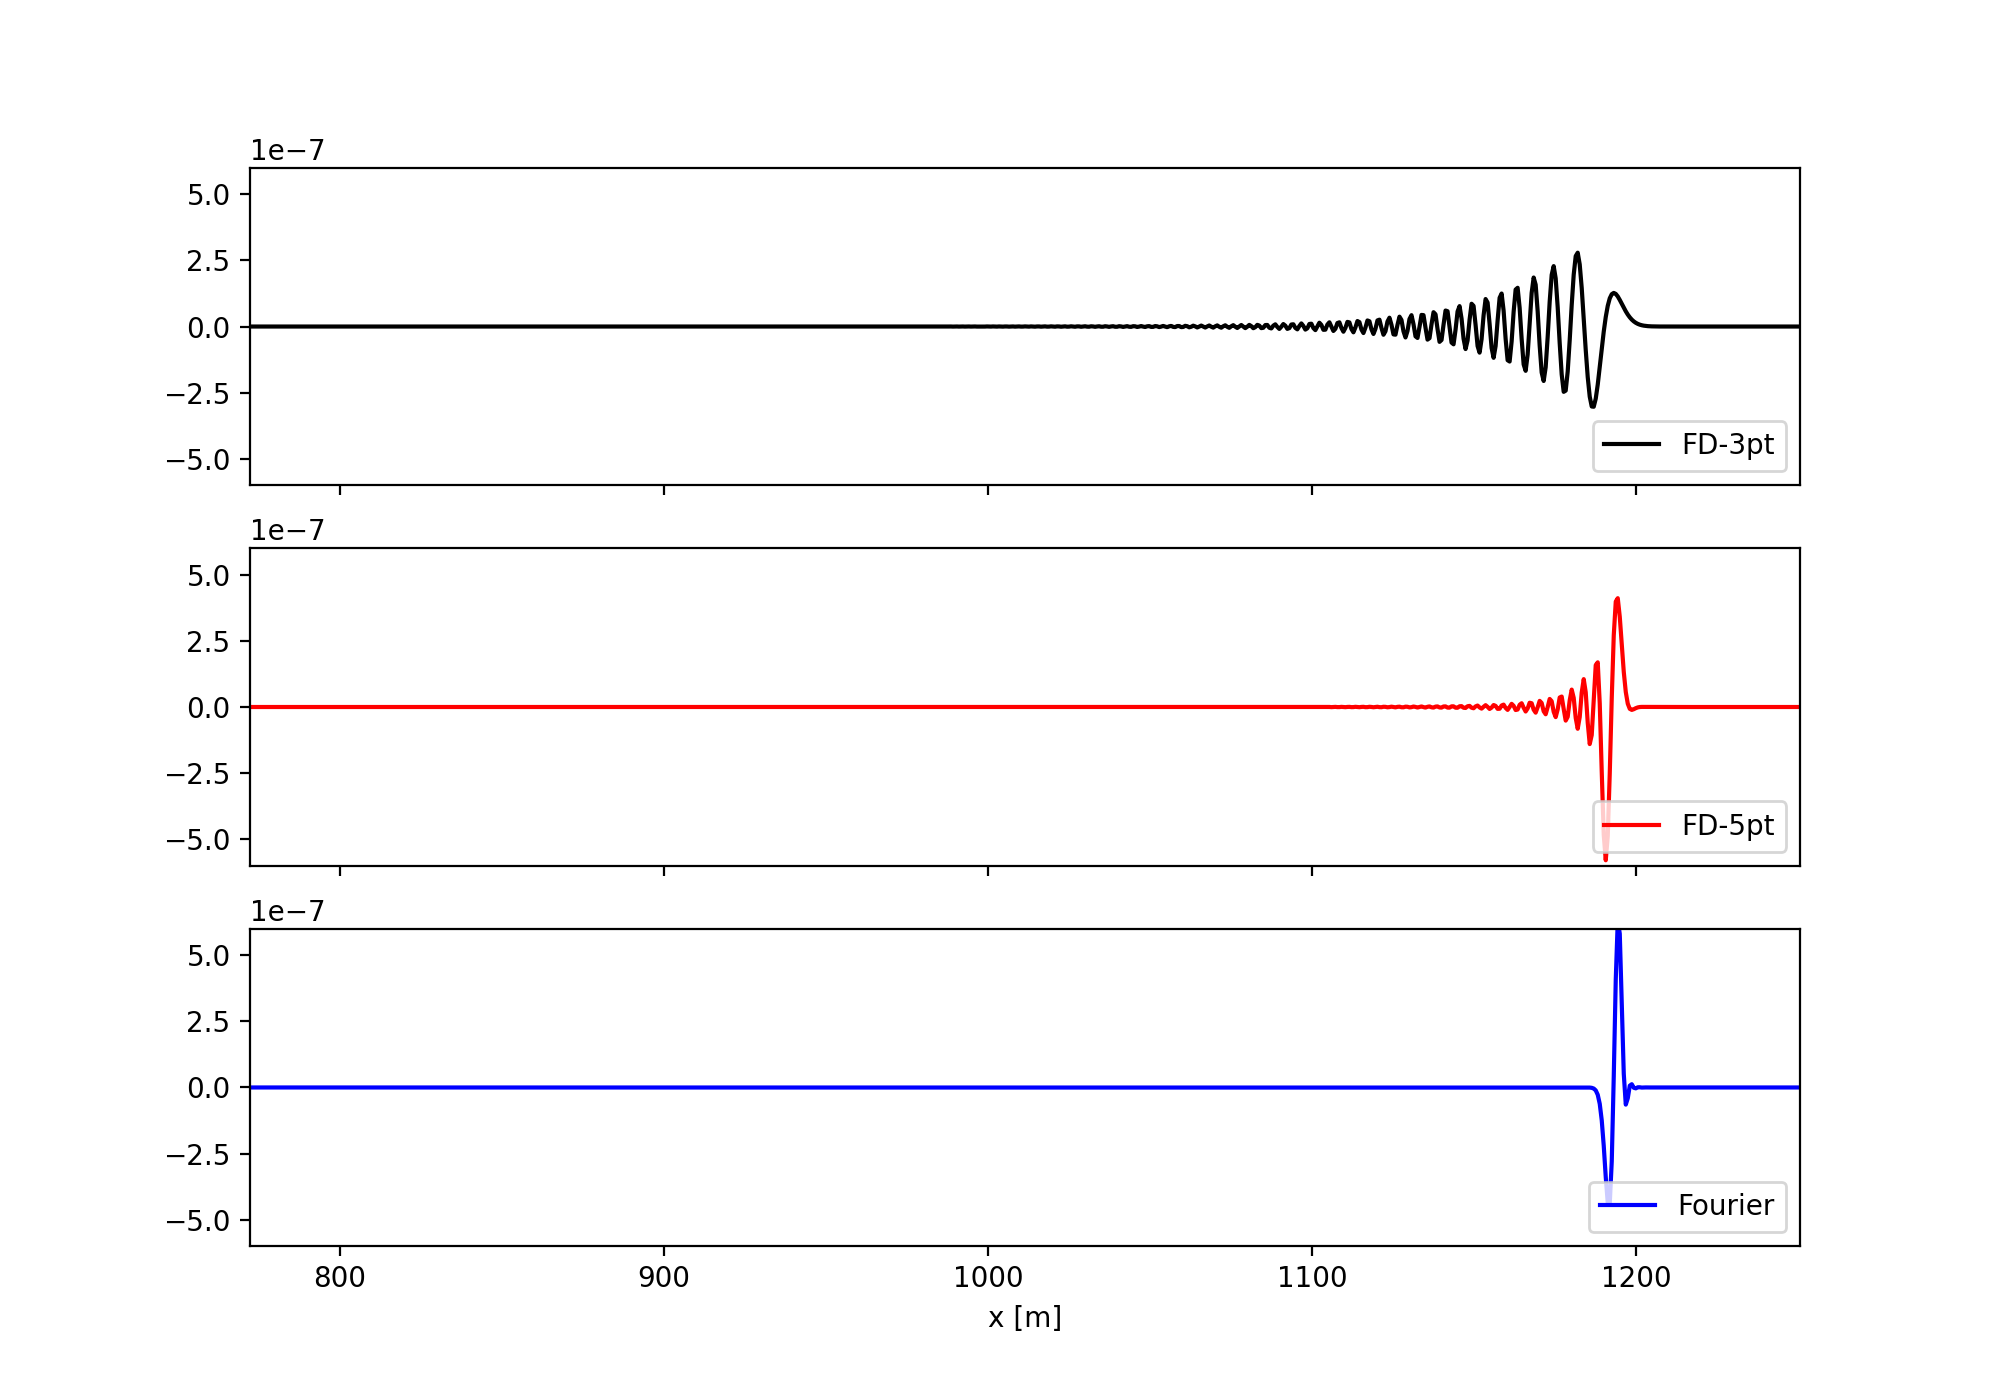

In [5]:
# ----------------------------------------------------------------
# Initialize animated plot
# ---------------------------------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(10,7))  
line1 = ax1.plot(x[isx:], p[isx:], 'k', lw=1.5, label='FD-3pt')
line2 = ax2.plot(x[isx:], ap[isx:], 'r', lw=1.5, label='FD-5pt')
line3 = ax3.plot(x[isx:], sp[isx:], 'b', lw=1.5, label='Fourier')
ax1.axis([isx*dx, nx*dx, -6E-7, 6E-7]); ax3.set_xlabel('x [m]')
ax1.legend(loc=4)  
ax2.legend(loc=4) 
ax3.legend(loc=4)

plt.ion()   # set interective mode
plt.show()

In [6]:
# Time extrapolation
# ---------------------------------------------------------------

for it in range(nt):
    # ----------------------------------------
    # Fourier Pseudospectral Method
    # ----------------------------------------           
    sd2p  = fourier_derivative_2nd(sp, dx)      # 2nd space derivative     
    spnew = 2*sp - spold + c**2 * dt**2 * sd2p  # Time Extrapolation   
    spnew = spnew + sg*src[it]*dt**2            # Add sources   
    spold, sp = sp, spnew                       # Time levels
    sp[1] = 0; sp[nx-1] = 0     # set boundaries pressure free
       
    # ----------------------------------------
    # Finite Differences Method 3pt
    # ----------------------------------------
    for i in range(1, nx-1):
        d2p[i] = (p[i+1] - 2*p[i] + p[i-1])/dx**2 # Space derivative          
    pnew = 2*p - pold + dt**2 * c**2 * d2p # Time Extrapolation    
    pnew = pnew + sg*src[it]*dt**2 # Add source    
    pold, p = p, pnew # Time levels
    p[0] = 0; p[nx-1] = 0 # set boundaries pressure free
        
    # ----------------------------------------
    # Finite Differences Method 5pt
    # ----------------------------------------
    for i in range(2, nx-2):
        ad2p[i] = (-1/12*ap[i+2] + 4/3*ap[i+1] - 5/2*ap[i] \
                   + 4/3*ap[i-1] - 1/12*ap[i-2])/dx**2 # Space derivative        
    apnew = 2*ap - apold + dt**2 * c**2 * ad2p # Time Extrapolation    
    apnew = apnew + sg*src[it]*dt**2 # Add source    
    apold, ap = ap, apnew # Time levels
    ap[0] = 0; ap[nx-1] = 0 # set boundaries pressure free
    
    # --------------------------------------   
    # Animation plot. Display solution
    if not it % isnap: 
        for l in line1:
            l.remove()
            del l               
        for l in line2:
            l.remove()
            del l
        for l in line3:
            l.remove()
            del l
            
        # -------------------------------------- 
        # Display lines
        line1 = ax1.plot(x[isx:], p[isx:], 'k', lw=1.5)
        line2 = ax2.plot(x[isx:], ap[isx:], 'r', lw=1.5)
        line3 = ax3.plot(x[isx:], sp[isx:], 'b', lw=1.5)
        plt.gcf().canvas.draw()
plt.show()

## Conclusions

- As expected the Fourier operator behaves substantially better then the finite difference approximations
- But we paied an high price in terms of calculations in order to have this precision with the Fourier operator.